# Boostvqe in Quantinuum

Following our example in the notebook `gci_boostvqe_circuit_synthesis.ipynb`, we will load the VQE and GCI circuits and run on Quantinuum Nexus emulators.

## Load VQE and GCI circuits

In [72]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime

In [123]:
vqe_circ_file = "results/vqe_circ_4.qasm"
gci_circ_file = "results/gci_circ_4.qasm"

In [124]:
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
# render_circuit_jupyter(vqe_circ)

In [125]:
gci_circ = pytket.qasm.circuit_from_qasm(gci_circ_file)
# render_circuit_jupyter(gci_circ)

Let us check the size of the GCI circuit.

In [126]:
print("Circuit depth:", gci_circ.depth())
print("Circuit total gate count:", gci_circ.n_gates)
num_cnots = sum(1 for command in gci_circ if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

Circuit depth: 235
Circuit total gate count: 632
Circuit CNOT count: 144


## Quantinuum preparation
Authentication - Create project - Set context

In [77]:
import qnexus as qnx

In [79]:
# connect to nexus account
qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      aCMXbV                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=aCMXbVpN2Fc7oVPrzcem6o3im3RMK73yublrdqULf_C0w2Q_K7FKZ5xEtlGP4whSKXiNzWZOVBRXiL2fUk1p0Q
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [148]:
# connect to nexus project
project_name = "boostvqe_demo_XXZ"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

## Energy expectation

We define the loss function as the energy expectation of $H$ with the rotated state $|\psi\rangle=U|0\rangle$, where the $U$ is implemented via the boostvqe circuit.

We will start with computing the expectation of a Pauli operator measured in the corresponding basis.

In [149]:
from pytket import Circuit
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit

In [150]:
def compute_expectation_paulistring(
    distribution: dict[tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    '''
    This function assumes that the bitmap is in the correct measurement basis
    and evaluates Pauli operators composed of Pauli.Z and Pauli.I.
    It calculates the expectation by counting the parity of the qubits being
    flipped.
    '''
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

Combining with the measurement setup and count results, the loss function can be defined:

In [151]:
def compute_expectation_value_from_results(
    results: list[BackendResult],
    measurement_setup: MeasurementSetup,
    operator: QubitPauliOperator,
) -> float:
    '''
    This function loops with the measurement_setup corresponding to the
    hamiltonian, select the corresponding string_coef, results index and
    calculates the total expectation of the input hamiltonian.
    '''
    energy = 0
    for pauli_string, bitmaps in measurement_setup.results.items():
        string_coeff = operator.get(pauli_string, 0.0)
        if string_coeff != 0:
            for bm in bitmaps:
                index = bm.circ_index
                distribution = results[index].get_distribution()
                value = compute_expectation_paulistring(distribution, bm)
                energy += complex(value * string_coeff).real
    return energy

### Hamiltonian in Pytket

In [152]:
def create_qubit_pauli_string(nqubits, specify_ls, coef):
    '''
    specify_ls: {index:Pauli.X/Y/Z}
    '''
    term = {}
    specified_ids = list(specify_ls.keys())
    for i in range(nqubits):
        if i in specified_ids:
            term.update({Qubit(i):specify_ls[i]})
        else:
            term.update({Qubit(i):Pauli.I})

    return {QubitPauliString(term):coef}

In [153]:
# XXZ model
nqubits = 4
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

### Measurement setup
Based on the hamiltonian in Pauli basis, we create a list of measurement setup for evaluating each non-commuting set of Pauli components of the hamiltonian.

In [154]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
# for mc in measurement_setup.measurement_circs:
#     render_circuit_jupyter(mc)

Here, we have created measurement circuits for the $X$, $Y$, and $Z$ terms. Next, we can upload and compile the measurement circuits.

## Compile circuits

We are now running noiseless emulation.

In [155]:
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    c = gci_circ.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

# compile vqe measurement circuit list
compiled_vqe_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=vqe_circuit_ref_list,
            optimisation_level=1,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_gci_circuit_refs = qnx.compile(
            name=f"compile_job_GCI_{datetime.now()}",
            circuits=gci_circuit_ref_list,
            optimisation_level=1,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

## Run circuits

In [173]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE") 

In [157]:
vqe_job_name = f"execute_job_VQE_{nshots}shots_{datetime.now()}"
gci_job_name = f"execute_job_GCI_{nshots}shots_{datetime.now()}"
results_vqe = qnx.start_execute_job(
            name=vqe_job_name,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci = qnx.start_execute_job(
            name=gci_job_name,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [158]:
from pathlib import Path
qnx.filesystem.save(
    ref=results_vqe,
    path=Path.cwd() / "results" / vqe_job_name,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci,
    path=Path.cwd() / "results" / gci_job_name,
    mkdir=True,
)

# Retrieve results

Without running repeated jobs, we can retrieve our results from the Qnexus project.

In [159]:
vqe_job_file = "results/execute_job_VQE_1000shots_2024-11-06 13:39:29.036185"
gci_job_file = "results/execute_job_VQE_2000shots_2024-11-06 16:01:11.142908"

In [160]:
vqe_job_ref = qnx.filesystem.load(
    path=Path.cwd() / vqe_job_file
)

gci_job_ref = qnx.filesystem.load(
    path=Path.cwd() / gci_job_file
)

In [164]:
print(qnx.jobs.status(vqe_job_ref))
print(qnx.jobs.status(gci_job_ref))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 6, 5, 42, 25, 66452, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 6, 5, 39, 30, 491358, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 6, 5, 42, 18, 369196, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 6, 8, 4, 10, 547260, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 6, 8, 1, 11, 896360, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 6, 8, 4, 4, 369275, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)


In [165]:
vqe_results = [job.download_result() for job in qnx.jobs.results(vqe_job_ref)]
gci_results = [job.download_result() for job in qnx.jobs.results(gci_job_ref)]

In [166]:
expval_vqe = compute_expectation_value_from_results(
    vqe_results, measurement_setup, ham_quantinuum
)
print(expval_vqe)

-4.8629999999999995


In [167]:
expval_gci = compute_expectation_value_from_results(
    gci_results, measurement_setup, ham_quantinuum
)
print(expval_gci)

-6.389


# With noise

In [174]:
backend_config = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)

In [194]:
vqe_job_name_with_noise = f"execute_job_VQE_{nshots}shots_noise_{datetime.now()}"
gci_job_name_with_noise = f"execute_job_GCI_{nshots}shots_noise_{datetime.now()}"
results_vqe_noise = qnx.start_execute_job(
            name=vqe_job_name_with_noise,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci_noise = qnx.start_execute_job(
            name=gci_job_name_with_noise,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [195]:
from pathlib import Path
qnx.filesystem.save(
    ref=results_vqe_noise,
    path=Path.cwd() / "results" / vqe_job_name_with_noise,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci_noise,
    path=Path.cwd() / "results" / gci_job_name_with_noise,
    mkdir=True,
)

### Load results with noise

In [196]:
vqe_job_file_noise = "results/execute_job_VQE_2000shots_noise_2024-11-06 16:38:36.896964"
gci_job_file_noise = "results/execute_job_GCI_2000shots_noise_2024-11-06 16:38:36.897157"

In [197]:
vqe_job_ref_noise = qnx.filesystem.load(
    path=Path.cwd() / vqe_job_file_noise
)

gci_job_ref_noise = qnx.filesystem.load(
    path=Path.cwd() / gci_job_file_noise
)

In [203]:
print(qnx.jobs.status(vqe_job_ref_noise))
print(qnx.jobs.status(gci_job_ref_noise))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 6, 8, 41, 46, 634279, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 6, 8, 38, 38, 941790, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 6, 8, 41, 39, 266966, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 6, 8, 42, 9, 893795, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 6, 8, 38, 39, 291804, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 6, 8, 41, 46, 787064, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)

In [204]:
vqe_results_noise = [job.download_result() for job in qnx.jobs.results(vqe_job_ref_noise)]
gci_results_noise = [job.download_result() for job in qnx.jobs.results(gci_job_ref_noise)]

In [205]:
expval_vqe_noise = compute_expectation_value_from_results(
    vqe_results_noise, measurement_setup, ham_quantinuum
)
print(expval_vqe_noise)

-6.152


In [206]:
expval_gci_noise = compute_expectation_value_from_results(
    gci_results_noise, measurement_setup, ham_quantinuum
)
print(expval_gci_noise)

-5.3950000000000005


# Prepare report

In [207]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [208]:
qibo.set_backend("numpy")

[Qibo 0.2.12|INFO|2024-11-06 16:43:20]: Using numpy backend on /CPU:0


[Qibo 0.2.12|WARNING|2024-11-06 16:43:20]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


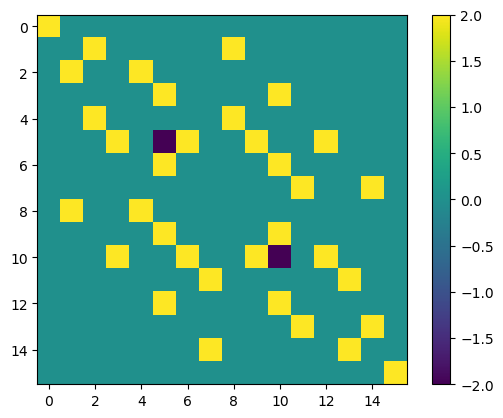

In [209]:
nqubits = 4
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

In [210]:
with open (vqe_circ_file, "r") as file:
    vqe_circuit_qasm_str = file.read()
    
with open (gci_circ_file, "r") as file:
    gci_circuit_qasm_str = file.read()

In [211]:
vqe_circ_qibo = qibo.models.Circuit.from_qasm(vqe_circuit_qasm_str)
gci_circ_qibo = qibo.models.Circuit.from_qasm(gci_circuit_qasm_str)

In [212]:
def report(vqe_circ, gci_circ, hamiltonian, expval_vqe, expval_gci, expval_vqe_noise, expval_gci_noise):
    energies = hamiltonian.eigenvalues()
    ground_state_energy = float(energies[0])
    vqe_energy = float(hamiltonian.expectation(vqe_circ().state()))
    gci_energy = float(hamiltonian.expectation(gci_circ().state()))
    gap = float(energies[1] - energies[0])
    return (
        dict(
            nqubits=hamiltonian.nqubits,
            gci_energy=float(gci_energy),
            vqe_energy=float(vqe_energy),
            vqe_energy_emulator=float(expval_vqe),
            gci_energy_emulator=float(expval_gci),
            vqe_energy_emulator_noise=float(expval_vqe_noise),
            gci_energy_emulator_noise=float(expval_gci_noise),
            target_energy=ground_state_energy,
            diff_vqe_target=vqe_energy - ground_state_energy,
            diff_gci_target=gci_energy - ground_state_energy,
            diff_vqe_target_emulator=expval_vqe - ground_state_energy,
            diff_gci_target_emulator=expval_gci - ground_state_energy,
            diff_vqe_target_emulator_noise=expval_vqe_noise - ground_state_energy,
            diff_gci_target_emulator_noise=expval_gci_noise - ground_state_energy,
            gap=gap,
            diff_vqe_target_perc=abs(vqe_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc=abs(gci_energy - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_vqe_target_perc_emulator=abs(expval_vqe - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc_emulator=abs(expval_gci - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_vqe_target_perc_emulator_noise=abs(expval_vqe_noise - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            diff_gci_target_perc_emulator_noise=abs(expval_gci_noise - ground_state_energy)
            / abs(ground_state_energy)
            * 100,
            fidelity_witness_vqe=1 - (vqe_energy - ground_state_energy) / gap,
            fidelity_witness_gci=1 - (gci_energy - ground_state_energy) / gap,
            fidelity_witness_vqe_emulator=1 - (expval_vqe - ground_state_energy) / gap,
            fidelity_witness_gci_emulator=1 - (expval_gci - ground_state_energy) / gap,
            fidelity_witness_vqe_emulator_noise=1 - (expval_vqe_noise - ground_state_energy) / gap,
            fidelity_witness_gci_emulator_noise=1 - (expval_gci_noise - ground_state_energy) / gap,
        )
    )

In [213]:
report_quantinuum = report(vqe_circ_qibo, gci_circ_qibo, ham, expval_vqe, expval_gci, expval_vqe_noise, expval_gci_noise)

In [214]:
import pandas as pd

In [215]:
# Creating a DataFrame for the table
df = pd.DataFrame({
    "Analytical": [
        report_quantinuum['vqe_energy'],
        report_quantinuum['gci_energy'],
        report_quantinuum['diff_vqe_target'],
        report_quantinuum['diff_gci_target'],
        report_quantinuum['diff_vqe_target_perc'],
        report_quantinuum['diff_gci_target_perc'],
        report_quantinuum['fidelity_witness_vqe'],
        report_quantinuum['fidelity_witness_gci']
    ],
    "Emulator": [
        report_quantinuum['vqe_energy_emulator'],
        report_quantinuum['gci_energy_emulator'],
        report_quantinuum['diff_vqe_target_emulator'],
        report_quantinuum['diff_gci_target_emulator'],
        report_quantinuum['diff_vqe_target_perc_emulator'],
        report_quantinuum['diff_gci_target_perc_emulator'],
        report_quantinuum['fidelity_witness_vqe_emulator'],
        report_quantinuum['fidelity_witness_gci_emulator']
    ],
    "Emulator with Noise": [
        report_quantinuum['vqe_energy_emulator_noise'],
        report_quantinuum['gci_energy_emulator_noise'],
        report_quantinuum['diff_vqe_target_emulator_noise'],
        report_quantinuum['diff_gci_target_emulator_noise'],
        report_quantinuum['diff_vqe_target_perc_emulator_noise'],
        report_quantinuum['diff_gci_target_perc_emulator_noise'],
        report_quantinuum['fidelity_witness_vqe_emulator_noise'],
        report_quantinuum['fidelity_witness_gci_emulator_noise']
    ]
}, index=[
    "VQE energy",
    "GCI energy",
    "Difference to target (VQE)",
    "Difference to target (GCI)",
    "Percentage difference to target (VQE)",
    "Percentage difference to target (GCI)",
    "Fidelity witness (VQE)",
    "Fidelity witness (GCI)"
])

# Display the DataFrame
df

,Analytical,Emulator,Emulator with Noise
VQE energy,-6.309812,-4.863000,-6.152000
GCI energy,-6.741348,-6.389000,-5.395000
Difference to target (VQE),0.434751,1.881563,0.592563
Difference to target (GCI),0.003215,0.355563,1.349563
Percentage difference to target (VQE),6.445942,27.897475,8.785783
Percentage difference to target (GCI),0.047665,5.271841,20.009639
Fidelity witness (VQE),0.841596,0.314440,0.784096
Fidelity witness (GCI),0.998829,0.870448,0.508278
